# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

---

<a id = 'title'></a>

## [Блок функций   (пишется параллельно предподготовке данных)](#func)

- [функция подготовки признака body / title](#func_0)
- [функция подготовки текстовых данных (нижний регистр / пунктуация)](#func_1)
- [функция бинаризации меток](#func_2)
- [функция построения матрицы неточностей](#func_3)
- [функция обучения простейшей модели логистической регрессии](#func_4)
- [функция обучения модели градиентного бустинга (Catboost)](#func_5)
- [функция подготовки датасета ко входу в модель](#func_6)
- [функция добавления результатов обученной модели](#func_7)


## [Загружаем фрейм , info() , drop_dublicates()](#download)

## [EDA](#eda)

- [назвать топ-15 банков по числу отзывов](#eda_1)
- [какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?](#eda_2)
- [сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов](#eda_3)
- [нет ли в данных в целом каких-то странностей на ваш взгляд?](#eda_4)
- [дополнительный EDA на ваше усмотрение, возможные интересные наблюдения](#eda_5)
    - [распределение рейтингов](#eda_5_0)
    - [предобработка отзывов](#eda_5_1)
    - [предобработка тем отзывов](#eda_5_2)


## [Классификация](#model)

- [предподготовка данных](#model__0)
- [Воспользуемся Upsampling](#model_0)
- [Трансформация признака title](#model_1)
- [Простейшая модель логистической регрессии (title проверка)](#model_2)
- [Трансформация признака body](#model_3)
- [Простейшая модель логистической регрессии (body проверка)](#model_4)
- [Трансформация признака bank_name](#model_5)
- [Трансформация признака date](#model_6)
- [Пользуемся написанной функцией preprocess (на выходе X_train, X_test, y_train, y_test c Upsampling)](#model_7)
- [LogReg](#model_8)
- [Catboost](#model_9)
- [SGDClassifier](#model_10)
- [Проверяем возможности на downsampling](#model_11)
- [Смотрим на проблемные предсказания](#model_12)
- [Смотрим на конкретные ошибки в предсказании](#model_13)
- [Вывод](#model_14)

In [105]:
# база
import pandas as pd
import numpy as np
import re
from datetime import datetime
import warnings
import joblib

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay


# подготовка ко входу в модель
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import scipy

# модели
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier

# метрика
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
stop_list = stopwords.words('russian')
result = pd.DataFrame()

<a id = 'func'></a>

## Блок функций

[к оглавлению](#title)

<a id = 'func_0'></a>

### функция подготовки признака body / title

[к оглавлению](#title)

In [106]:
def body_preprocess(string):
    string = string.lower()
    string = string.replace('ё', 'е')
    string = re.sub('[^А-Яа-я0-9,?!.]', ' ', string)
    string = re.sub(" +", " ", string).strip()
    return string

<a id = 'func_1'></a>

### функция подготовки текстовых данных (нижний регистр / пунктуация)

[к оглавлению](#title)

In [107]:
def preprocess_text(stroka):    
    stroka = stroka.lower() # в нижний регистр
    for c in string.punctuation:    # убираем пунктуацию
        stroka = stroka.replace(c, '')
    # string_list = stroka.split()
    # string_list =\
    # [word for word in string_list if word not in stop_list]

    # porter = PorterStemmer()
    # string_list =\
    # [porter.stem(word) for word in string_list]
    return stroka

<a id = 'func_2'></a>

### функция бинаризации меток

[к оглавлению](#title)

In [108]:
def rating_binary(x):
    if x < 3:
        return 0
    else:
        return 1

<a id = 'func_3'></a>

### функция построения матрицы неточностей

[к оглавлению](#title)

In [109]:
def confusion_matrix_plot(y_test, y_pred):
    matrix = \
    confusion_matrix(y_test,
                     y_pred)

    matrix = pd.DataFrame(matrix, columns = ['прогноз: 0', 'прогноз 1'], index = ['фактически: 0', 'фактически: 1'])
    plt.figure(figsize = (5,5))
    ax = \
    sns.heatmap(matrix,
                cmap = 'PiYG', # цветовая гамма
                cbar = False,   # отключить бар справа
                annot = True,   # показывать числа
                fmt="") # в каком виде числа: ".1f" - одно число после запятой
    plt.title('Матрица неточностей бинарного классификатора: классификация 0 или 1 \n \n')
    ax.xaxis.tick_top()
    plt.show()

<a id = 'func_4'></a>

### функция обучения простейшей модели логистической регрессии

[к оглавлению](#title)

In [110]:
def simple_logistic_regression(
        X_train,
        y_train,
        X_test,
        y_test,
        name_preprocess = None
):
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_test)

    if name_preprocess:
        print('Тестовая оценка с преобразованием:', name_preprocess, 'score: ', score)
    else:
        print('score: ', score)
    return model

<a id = 'func_5'></a>

### функция обучения модели градиентного бустинга (Catboost)

[к оглавлению](#title)

In [111]:
def catboost_model(
    plot_mode,

    X_train, y_train,
    X_test, y_test,
    
    iter,
    lr
    ):

    model = CatBoostClassifier(
        iterations = iter,
        learning_rate = lr,
        random_seed = RANDOM_STATE,
        custom_loss = ['Accuracy'],
        use_best_model = True, # Обрубает не нужные итерации
        early_stopping_rounds = 20, # Если на протяжении 20 итерациях ошибка не уменьшается - остановка обучения
        eval_metric = 'Accuracy')

    model.fit(X_train,
              y_train,
              eval_set = (X_test, y_test),
              verbose = 0,
              plot = plot_mode)

    model.get_params()
    model.best_score_
    return model

<a id = 'func_6'></a>

### функция подготовки датасета ко входу в модель

[к оглавлению](#title)

In [112]:
def preprocess(
        mode_dataset, # 'upsampling', 'downsampling'    
        calendar_features, # ['year', 'month', 'day', 'weekday']
        return_index_test_and_transformer = False, # bool ## Для последующей проверки ошибок
):
    data = pd.read_csv('parsed_reviews3.csv')
    data = data.drop_duplicates()
    data['body'], data['title'] = data['body'].map(body_preprocess), data['title'].map(body_preprocess)
    data['date'] = pd.to_datetime(data['date'])
    data['rating'] = data['rating'].map(rating_binary)

    if 'year' in calendar_features:
        data['year'] = data['date'].dt.year
    if 'month' in calendar_features:
        data['month'] = data['date'].dt.month
    if 'day' in calendar_features:
        data['day'] = data['date'].dt.day
    if 'weekday' in calendar_features:
        data['weekday'] = data['date'].dt.weekday

    # class_1 = data[data['rating'] == 1]
    # class_0 = data[data['rating'] == 0]
    # len_min_class = len(class_0)
    # len_max_class = len(class_1)

    # if mode_dataset == 'upsampling':
    #     ratio = int(len_max_class / len_min_class)
    #     class_0 = class_0.loc[class_0.index.repeat(ratio)]
    #     data = pd.concat([class_1,class_0], ignore_index = True).sample(frac = 1,
    #                                                                     random_state = RANDOM_STATE)
    # else:
    #     indexses_to_downsampling = data[data['rating'] == 1].index #  это больший класс 
    #     new_indexes_down = np.random.permutation(indexses_to_downsampling)[:len_min_class]

    #     data = \
    #     pd.concat([class_0,
    #                data[data['rating'] == 1].loc[new_indexes_down]])

    # y = data['rating']
    # X = data.drop('rating', axis = 1)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)


    train, test = train_test_split(data, test_size = 0.2, stratify = data['rating'], random_state = RANDOM_STATE)

    class_1 = train[train['rating'] == 1]
    class_0 = train[train['rating'] == 0]
    len_min_class = len(class_0)
    len_max_class = len(class_1)

    if mode_dataset == 'upsampling':
        ratio = int(len_max_class / len_min_class)
        class_0 = class_0.loc[class_0.index.repeat(ratio)]
        train = pd.concat([class_1,class_0], ignore_index = True).sample(frac = 1,
                                                                         random_state = RANDOM_STATE)
    else:
        indexses_to_downsampling = train[train['rating'] == 1].index #  это больший класс 
        new_indexes_down = np.random.permutation(indexses_to_downsampling)[:len_min_class]

        train = \
        pd.concat([class_0,
                   train[train['rating'] == 1].loc[new_indexes_down]])

    y_train = train['rating']
    X_train = train.drop('rating', axis = 1)
    
    y_test = test['rating']
    X_test = test.drop('rating', axis = 1)


    bank_index = (X_test['bank_name'].isin(X_train['bank_name']) == True).reset_index().rename({'bank_name': 'bool'}, axis = 1)
    bank_index_t_t = bank_index[bank_index['bool'] == True]['index']
    X_test = X_test.loc[bank_index_t_t]
    y_test = y_test.loc[bank_index_t_t]

    INDEX_SPARSE___INDEXES_TEST_SERIES = pd.Series(X_test.index)
    
    # TF-IDF предобработка текстовых данных (признаки : body, title)
    tfidf_body = TfidfVectorizer()
    tfidf_body.fit(train['body']) # !!!!!!!

    train_body_tfidf = tfidf_body.transform(X_train['body'])
    test_body_tfidf  = tfidf_body.transform(X_test['body'])

    tfidf_title = TfidfVectorizer()
    tfidf_title.fit(train['title']) # !!!!!!!

    train_title_tfidf = tfidf_title.transform(X_train['title'])
    test_title_tfidf = tfidf_title.transform(X_test['title'])


    # bank_name
    one_hot_encoder = OneHotEncoder()
    bank_name_matrix_train = one_hot_encoder.fit_transform(np.array(X_train['bank_name']).reshape(-1,1))
    bank_name_matrix_test = one_hot_encoder.transform(np.array(X_test['bank_name']).reshape(-1,1))
    
    # scaler
    scaler = StandardScaler()
    calendar_features_train = scaler.fit_transform(X_train[calendar_features])
    calendar_features_test = scaler.transform(X_test[calendar_features])


    
    massive_train = scipy.sparse.hstack((train_body_tfidf, train_title_tfidf))
    sparse_matrix_bank_name_train = scipy.sparse.csr_matrix(bank_name_matrix_train)
    sparse_matrix_calendar_train = scipy.sparse.csr_matrix(calendar_features_train)

    X_train = scipy.sparse.hstack((massive_train, sparse_matrix_bank_name_train, sparse_matrix_calendar_train))


    massive_test = scipy.sparse.hstack((test_body_tfidf, test_title_tfidf))
    sparse_matrix_bank_name_test = scipy.sparse.csr_matrix(bank_name_matrix_test)
    sparse_matrix_calendar_test = scipy.sparse.csr_matrix(calendar_features_test)

    X_test = scipy.sparse.hstack((massive_test, sparse_matrix_bank_name_test, sparse_matrix_calendar_test))

    # print('Параметры данных: {}, список календарных признаков: {}'.format(mode_dataset, calendar_features))
    # print('Размер тренировочной матрицы: {}, размер тренировочных меток: {}'.format(X_train.shape, y_train.shape))
    # print('Размер валидационного набора: {}, размер валидационных меток: {}'.format(X_test.shape, y_test.shape))
    if return_index_test_and_transformer:
        return X_train, X_test, y_train, y_test, INDEX_SPARSE___INDEXES_TEST_SERIES, tfidf_body
    else:
        return X_train, X_test, y_train, y_test

<a id = 'func_7'></a>

### функция добавления результатов обученной модели

[к оглавлению](#title)

In [113]:
def result_to_frame(
        result_frame,
        name_classifier,
        name_balance_mode,
        model,
        X_test,
        y_test
):
    
    y_pred = model.predict(X_test)

    if name_classifier == 'log_reg':
        test_acc = accuracy_score(y_pred = y_pred,
                                  y_true = y_test)
        res = {
            'name': name_classifier,
            'balance_mode': name_balance_mode,
            'solver': model.get_params()['solver'],
            'iteration': model.get_params()['max_iter'],
            'penalty': model.get_params()['penalty'],
            'test_acc': test_acc
            }

        result_frame = pd.concat([result_frame, pd.Series(res)],axis = 1)
    
    if name_classifier == 'catboost':
        res = \
        {'name': name_classifier,
         'balance_mode': name_balance_mode,
        'train_acc': model.best_score_['learn']['Accuracy'],
        'train_loss': model.best_score_['learn']['Logloss'],
        'iteration': model.get_params()['iterations'],
        'lr': model.get_params()['learning_rate'],
        'test_acc':model.best_score_['validation']['Accuracy'],
        'test_loss': model.best_score_['validation']['Accuracy']
        }
        result_frame = pd.concat([result_frame, pd.Series(res)], axis = 1)

    if name_classifier == 'sgd':
        test_acc = accuracy_score(y_pred = y_pred,
                                  y_true = y_test)
        res = {
        'name': name_classifier,
        'balance_mode': name_balance_mode,
       'iteration': model.get_params()['max_iter'],
       'penalty': model.get_params()['penalty'],
       'test_acc':test_acc
       }
        
        result_frame = pd.concat([result_frame, pd.Series(res)], axis = 1)
        
    return result_frame

<a id = 'func_8'></a>

### функция анализа получившихся результатов

[к оглавлению](#title)

In [114]:
def problem_analyst(
        data,
        X_test_in_sparse_type,
        y_pred,
        y_test,
        TEST_FRAME_INDEX,
        index_you_want, # индекс начинается с 0 (фрейм отсортирован по возрастанию длины отзыва)
        real_class, # класс ошибки, которую хотим оценить ( 0 или 1 )
        transformer, # после fit
):
    data_result_conf_matrix_proba = (y_pred != y_test).reset_index().rename({'rating': 'bool'}, axis = 1)
    indexes_failed = data_result_conf_matrix_proba[data_result_conf_matrix_proba['bool'] == True]['index']
    fail_proba = data.loc[indexes_failed]

    fail_proba['len_body'] = fail_proba['body'].map(lambda x: len(x))
    fail_proba = fail_proba.sort_values(by = 'len_body')

    if real_class == 0:
        fail_proba = fail_proba[fail_proba['rating'] == 0]
    else:
        fail_proba = fail_proba[fail_proba['rating'] == 1]
    
    index_data = pd.DataFrame(TEST_FRAME_INDEX).rename({0: 'index_in_frame'}, axis = 1)
    our_index_in_sparse = index_data[index_data['index_in_frame'] == fail_proba.index[index_you_want]].index[0] 

    data_proverka = pd.DataFrame(X_test_in_sparse_type[our_index_in_sparse, :len(transformer.vocabulary_)].toarray()[0])
        
    voc =\
        pd.Series(transformer.vocabulary_)\
                        .reset_index()\
                        .rename({'index': 'слово', 0: 'векторное представление слова'}, axis = 1)\
                        .sort_values(by = 'векторное представление слова')
    words =\
    pd.DataFrame(np.concatenate((data_proverka.values, voc.values), axis = 1),
                columns  = ['частота', 'слово', 'векторное представление'])
    
    print('СЛОВА В ОТЗЫВЕ, У КОТОРЫХ ЧАСТОТА TF-IDF НЕ 0')
    print('_____________________________________________')
    rating = fail_proba.loc[fail_proba.index[0]]['rating']
    print('Реальный рейтинг выбранного отзыва: ', rating)
    print('_____________________________________________')
    print('Текст отзыва: ')
    print(fail_proba.loc[fail_proba.index[index_you_want]][0])
    print('_____________________________________________')
    return words[words['частота'] != 0]

<a id = 'download'></a>

## Загружаем фрейм , info() , drop_dublicates()

[к оглавлению](#title)

In [115]:
data = pd.read_csv('parsed_reviews3.csv')
data.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [117]:
data.duplicated().sum()

62

In [118]:
data = data.drop_duplicates()

<a id = 'eda'></a>

## EDA

[к оглавлению](#title)

<a id = 'eda_1'></a>

### Назвать топ-15 банков по числу отзывов

[к оглавлению](#title)

Text(0, 0.5, 'название банка')

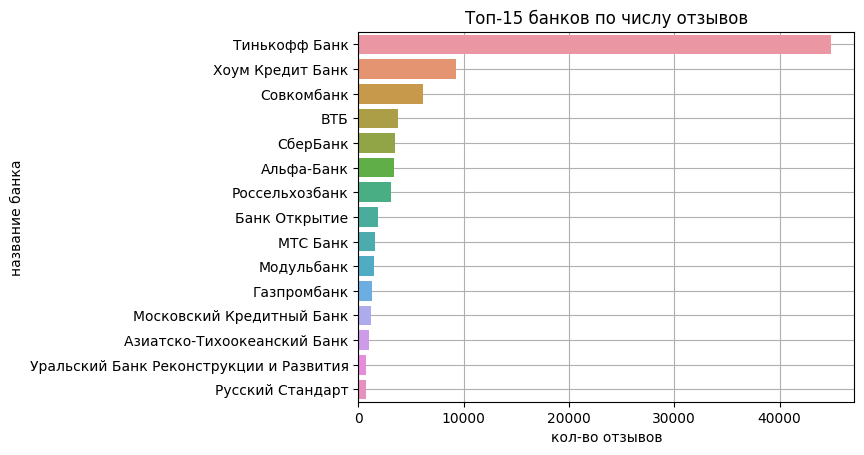

In [119]:
eda_1 = data.groupby('bank_name')['body'].count()\
                                         .sort_values(ascending = False)[:15]\
                                         .reset_index()
ax =\
sns.barplot(data = eda_1,
            x = 'body',
            y = 'bank_name')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Топ-15 банков по числу отзывов')
plt.xlabel('кол-во отзывов')
plt.ylabel('название банка')

,bank_name,body,percent
0,Тинькофф Банк,44852,48
1,Хоум Кредит Банк,9301,10
2,Совкомбанк,6100,6
3,ВТБ,3814,4
4,СберБанк,3487,3
5,Альфа-Банк,3368,3
6,Россельхозбанк,3062,3
7,Банк Открытие,1894,2
8,МТС Банк,1542,1
9,Модульбанк,1452,1


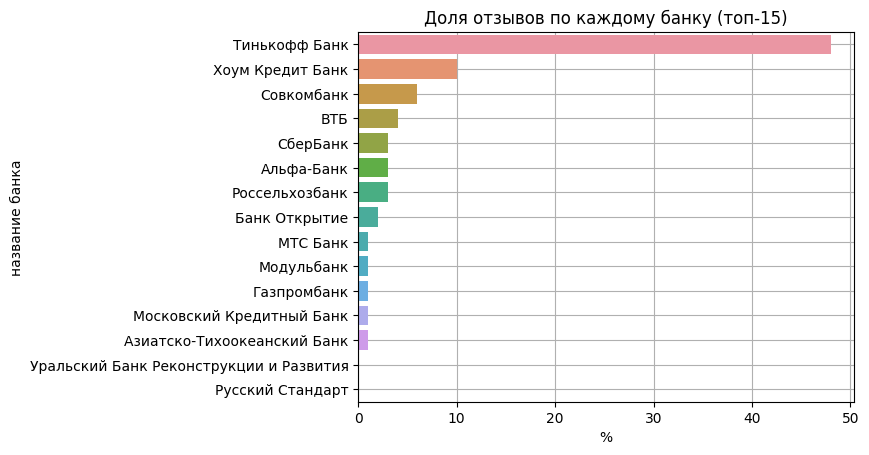

In [120]:
# Посчитаем процент отзывов от всего кол-ва, для большей наглядности
all_bodyes = len(data['body'])
eda_1['percent'] = ((eda_1['body'] / all_bodyes)*100).astype('int')
eda_1

ax =\
sns.barplot(data = eda_1,
            x = 'percent',
            y = 'bank_name')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Доля отзывов по каждому банку (топ-15)')
plt.xlabel('%')
plt.ylabel('название банка')

eda_1

- Тинькофф банк лидирует по кол-ву отзывов (почти половина отзывов)
- Хоум кредит, Совком в топ-3
- У ВТБ, Сбер, Альфа, Россельхоз схожее кол-во отзывов

<a id = 'eda_2'></a>

### Какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?

[к оглавлению](#title)

,bank_name,body,percent,rating
0,Тинькофф Банк,44852,48,4.784
9,Модульбанк,1452,1,4.779
12,Азиатско-Тихоокеанский Банк,1000,1,4.718
1,Хоум Кредит Банк,9301,10,4.506
6,Россельхозбанк,3062,3,4.456


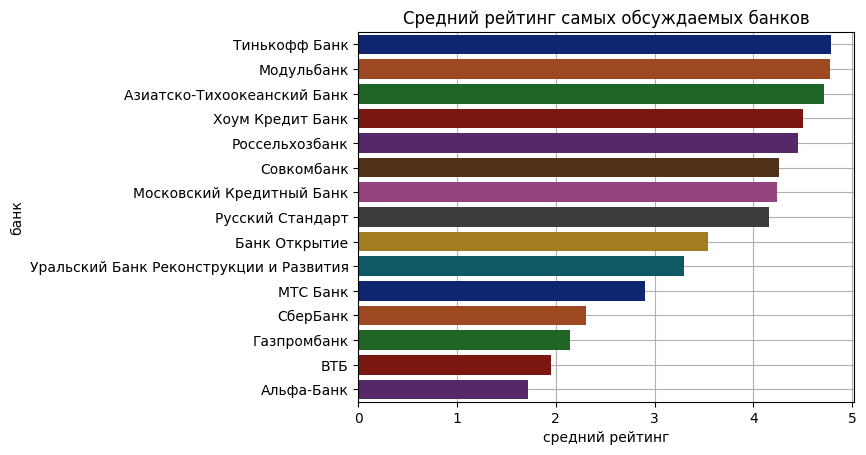

In [121]:
eda_2 = data.groupby('bank_name')['rating'].mean()\
                                           .round(3)\
                                           .reset_index()
eda_2 =\
eda_1.merge(eda_2,
            on = 'bank_name').sort_values(by = 'rating',
                                          ascending = False)

ax =\
sns.barplot(data = eda_2,
            x = 'rating',
            y = 'bank_name',
            palette = 'dark')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Средний рейтинг самых обсуждаемых банков')
plt.xlabel('средний рейтинг')
plt.ylabel('банк')

eda_2.head()

- Наибольший средний рейтинг у Тинькофф Банка (4.784)
- У Модульбанка - 4.78, но кол-во отзывов намного ниже !

<a id = 'eda_3'></a>

### Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

[к оглавлению](#title)

In [122]:
eda_3 = eda_1.head()

data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['year_month'] = data['date'].dt.date.astype('datetime64[M]')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92673 entries, 0 to 92734
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   body        92673 non-null  object        
 1   title       92673 non-null  object        
 2   rating      92673 non-null  int64         
 3   bank_name   92673 non-null  object        
 4   date        92673 non-null  datetime64[ns]
 5   month       92673 non-null  int64         
 6   year        92673 non-null  int64         
 7   year_month  92673 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 6.4+ MB


In [123]:
print('Уникальные года из фрейма: {}'.format(data['year'].unique()))
print('Уникальные месяца из фрейма: {}'.format(data['month'].unique()))

Уникальные года из фрейма: [2023 2022]
Уникальные месяца из фрейма: [ 1 12 11 10  9]


In [124]:
eda_3_1 = data.groupby(['year_month','bank_name'])['rating'].mean()\
                                                            .round(3)\
                                                            .reset_index()
eda_3 =\
eda_3.merge(eda_3_1,
            on = ['bank_name'])

# Создадим колонку для удобного графического представления
eda_3['year_month_for_graph'] = eda_3['year_month'].map(lambda x: datetime.strftime(x, '%Y-%m'))
eda_3.head()

,bank_name,body,percent,year_month,rating,year_month_for_graph
0,Тинькофф Банк,44852,48,2022-09-01,3.888,2022-09
1,Тинькофф Банк,44852,48,2022-10-01,4.866,2022-10
2,Тинькофф Банк,44852,48,2022-11-01,4.842,2022-11
3,Тинькофф Банк,44852,48,2022-12-01,4.650,2022-12
4,Тинькофф Банк,44852,48,2023-01-01,3.990,2023-01


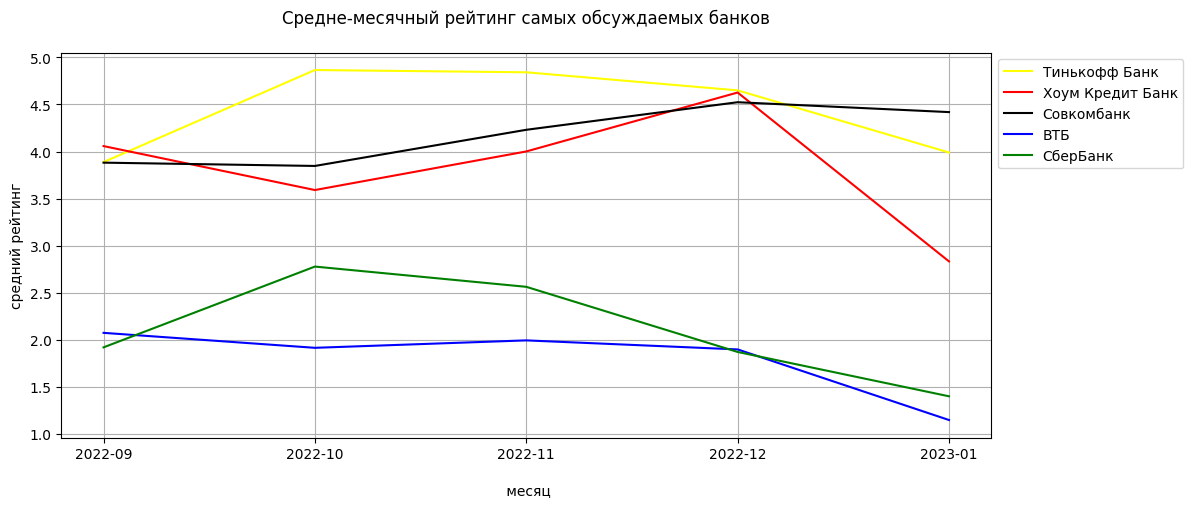

In [125]:
# словарь цветов для каждого банка
slovar = {'Тинькофф Банк': 'yellow',
          'Хоум Кредит Банк': 'red',
          'Совкомбанк': 'black',
          'ВТБ': 'blue',
          'СберБанк': 'green'}

plt.figure(figsize = (12,5))
for name, color in slovar.items():
    ax =\
    sns.lineplot(data = eda_3[eda_3['bank_name'] == name],
                x = 'year_month_for_graph',
                y = 'rating',
                color = color,
                label = name)

    plt.grid()
    ax.set_axisbelow(b = True)
    plt.title('Средне-месячный рейтинг самых обсуждаемых банков\n')
    plt.xlabel('\n месяц')
    plt.ylabel('средний рейтинг')
    plt.legend(bbox_to_anchor = (1,1))

- с сентября по октябрь 2022:
    - Тинькофф и Сбер росли:
        - Тинькофф: 3.8 --> 4.8
        - Сбер:     1.9 --> 2.7
    - у остальных же - небольшое падение, но у Хоум Кредита - серьезное падение на пол пункта

- с октября по ноябрь 2022:
    - Тинькофф, ВТБ - стационарны
        - Тинькофф: 4.8
        - ВТБ:      1.9
    - Совкомбанк, Хоум Кредит - равнозначный рост на пол пункта
    - СберБанк - незначительное падение: 2.7 --> 2.5

- с ноября по декабрь 2022:
    - Тинькофф, ВТБ - незначительное падение
        - Тинькофф: 4.8 --> 4.6
        - ВТБ:      2.0 --> 1.9
    - Сбербанк - падение:  2.5 --> 1.8   
    - Хоум Кредит - рост:  4.0 --> 4.6
    - Совком - рост: 4.2 --> 4.5

- с декабря 2022 по январь 2023 у всех наблюдалось падение рейтинга:
    - Тинькофф: 4.6 --> 3.9 !
    - СберБанк: 1.8 --> 1.4
    - ВТБ: 1.8 --> 1.1 !
    - Хоум Кредит 4.6 --> 2.8 !!!!
    - Совком 4.5 --> 4.4


<font color='red'>ИТОГО: </font>

- Тинькофф: в совокупности - самый высокий средний рейтинг из топ-5
- Совкомбанк: наблюдается тенденция к росту рейтингов (выше 3.7 за рассматриваемый период)
- ХоумКредит: колошматит, но средний рейтинг сентябрь - декабрь 2022 выше 3.5
- СберБанк: значительный рост до октября, далее падение (2.7 на пике)
- ВТБ: стабильно маленький рейтинг (постоянно ниже 2.0)

- У всех банков наблюдается падение в январе 2023

<a id = 'eda_4'></a>

### Нет ли в данных в целом каких-то странностей на ваш взгляд?

[к оглавлению](#title)

In [126]:
data['day'] = data['date'].dt.date

eda_4_1 = \
data.groupby('day')['body'].count()\
                           .sort_values(ascending = False)\
                           .reset_index()
eda_4_1.head()

,day,body
0,2022-10-27,7627
1,2022-12-09,4364
2,2022-10-28,4212
3,2022-11-02,2219
4,2022-12-08,2162


[Text(19236.0, 0, '2022-09-01'),
 Text(19250.0, 0, '2022-09-15'),
 Text(19266.0, 0, '2022-10-01'),
 Text(19280.0, 0, '2022-10-15'),
 Text(19297.0, 0, '2022-11-01'),
 Text(19311.0, 0, '2022-11-15'),
 Text(19327.0, 0, '2022-12-01'),
 Text(19341.0, 0, '2022-12-15'),
 Text(19358.0, 0, '2023-01-01')]

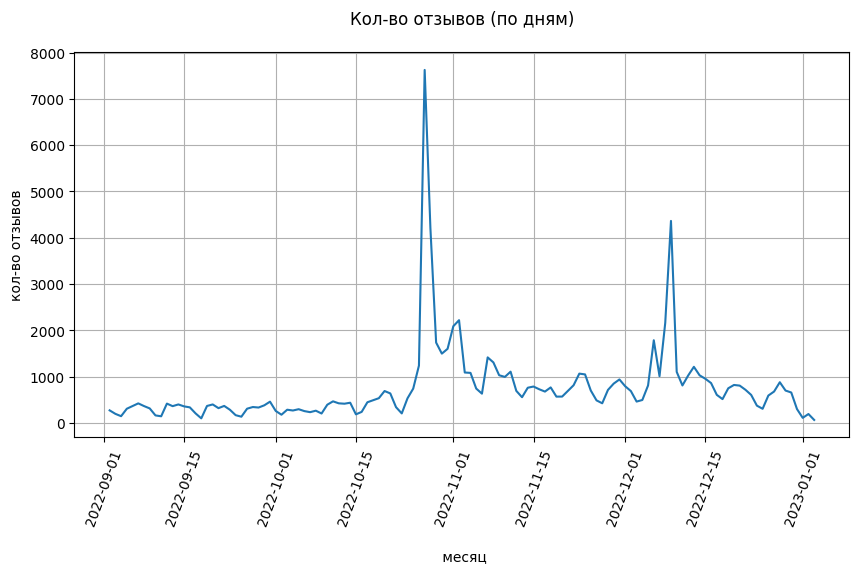

In [127]:
plt.figure(figsize = (10, 5))
ax =\
sns.lineplot(data = eda_4_1,
             x = 'day',
             y = 'body')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Кол-во отзывов (по дням)\n')
plt.xlabel('\n месяц')
plt.ylabel('кол-во отзывов')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

Text(0, 0.5, 'кол-во отзывов')

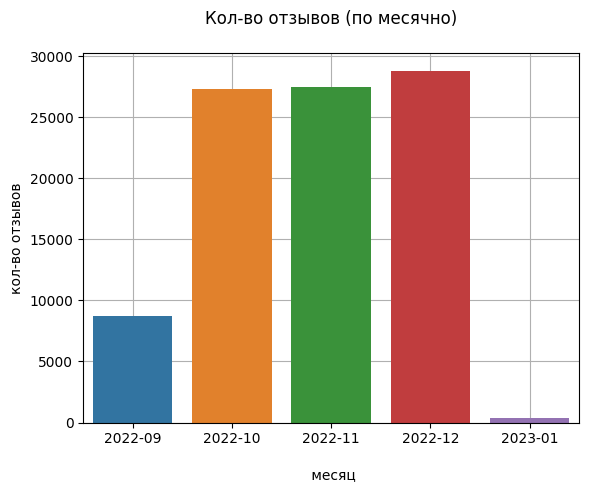

In [128]:
eda_4 = data.groupby('year_month')['body'].count().reset_index()
eda_4['for_graph'] = eda_4['year_month'].map(lambda x: datetime.strftime(x, '%Y-%m'))

ax =\
sns.barplot(data = eda_4,
            x = 'for_graph',
            y = 'body')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Кол-во отзывов (по месячно)\n')
plt.xlabel('\n месяц')
plt.ylabel('кол-во отзывов')

- Всплеск кол-ва отзывов на сайте в 10,11,12 месяцах
- Максимальное кол-во отзывов было написано 27/28 октября 2022 (7627 / 4213 отзывов)
- Также всплекс активности замечен 9 декабря 2022 года (4364 отзывов)

<a id = 'eda_5'></a>

### Дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

[к оглавлению](#title)

<a id = 'eda_5_0'></a>

#### Распределение рейтингов

[к оглавлению](#title)

Text(0, 0.5, 'кол-во')

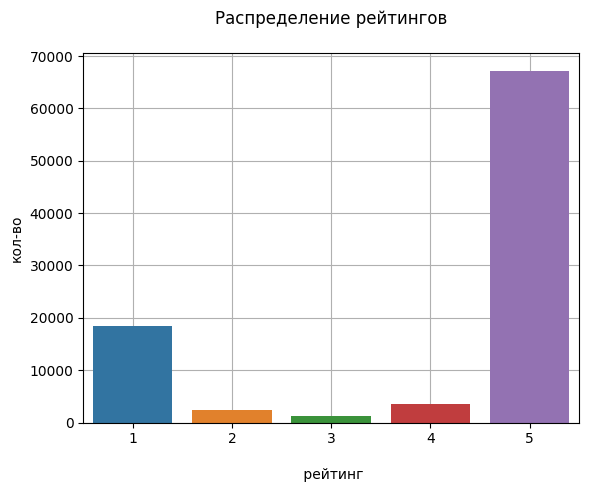

In [129]:
ax =\
sns.barplot(data = data.groupby('rating')['bank_name'].count().reset_index(),
            x = 'rating',
            y = 'bank_name')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Распределение рейтингов\n')
plt.xlabel('\n рейтинг')
plt.ylabel('кол-во')

Text(0, 0.5, 'банк')

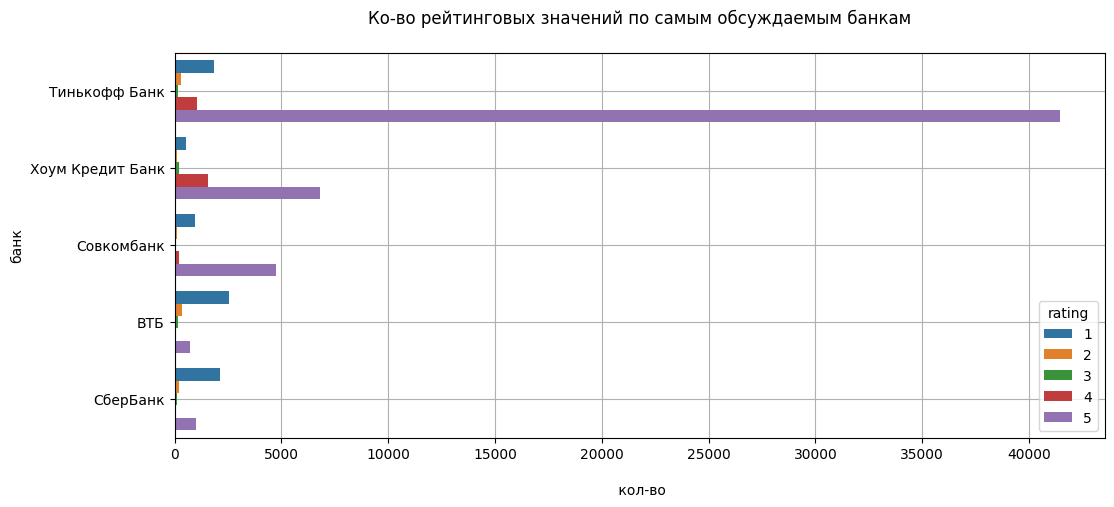

In [130]:
eda_5_ = eda_1.head()
eda_5_00 = \
eda_5_.merge(data.groupby(['bank_name', 'rating'])['month'].count()\
                                                           .reset_index()\
                                                           .rename({'month': 'rating_count'}, axis = 1),
            on = 'bank_name')

plt.figure(figsize = (12,5))
ax =\
sns.barplot(data = eda_5_00,
            y = 'bank_name',
            x = 'rating_count',
            hue = 'rating')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Ко-во рейтинговых значений по самым обсуждаемым банкам\n')
plt.xlabel('\n кол-во')
plt.ylabel('банк')

<a id = 'eda_5_1'></a>

#### Предобработка отзывов

[к оглавлению](#title)

In [131]:
# Предобработаем отзывы и посмотрим, какие темы отзывов более характерны для каждого банка, или они одинаковые
# Напишем функцию предобработки отзывов

data['body'] = data['body'].map(body_preprocess)
data.head()

,body,title,rating,bank_name,date,month,year,year_month,day
0,добрый день пишу сюда для более скорого разреш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,2023,2023-01-01,2023-01-03
1,"при возврате просроченной задолженности, банк ...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,2023,2023-01-01,2023-01-03
2,07.09.22 ю была оформлена кредитная карта 120 ...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,2023,2023-01-01,2023-01-03
3,новый год начинается с приятностей никогда не ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023,2023-01-01,2023-01-03
4,увидела на сайте газпромбанка акцию с бонусом ...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,2023,2023-01-01,2023-01-03


40924    3663
41036    3647
28449    3628
29237    3625
21798    3622
         ... 
2962       11
3910       11
50820      10
15513       7
54696       5
Name: body_len, Length: 92673, dtype: int64


count    92673.00
mean       604.10
std        495.36
min          5.00
25%        327.00
50%        405.00
75%        659.00
max       3663.00
Name: body_len, dtype: float64

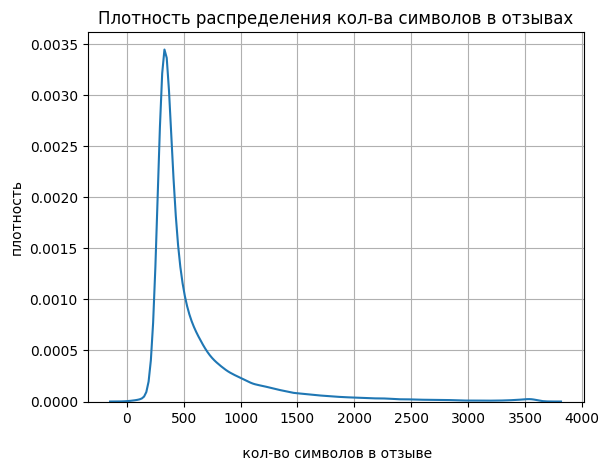

In [132]:
# Посчитаем кол-во символов в каждом отзыве
data['body_len'] = data['body'].map(lambda x: len(x))

sns.kdeplot(data = data,
            x = 'body_len')
plt.grid()
ax.set_axisbelow(b = True)
plt.title('Плотность распределения кол-ва символов в отзывах')
plt.xlabel('\n кол-во символов в отзыве')
plt.ylabel('плотность')


print(data['body_len'].sort_values(ascending = False))
data['body_len'].describe().round(2)

<a id = 'eda_5_2'></a>

#### Предобработка тем отзывов

[к оглавлению](#title)

In [133]:
print('Уникальных тем отзывов до предобработки: {}'.format(len(data['title'].unique())))

Уникальных тем отзывов до предобработки: 54505


In [134]:
data[data['rating'] != 5]['title']

0                                   Заблокировали средства
1                       Возврат просроченной задолженномти
2        Ошибочное начисление комиссии, затягивание про...
4        Как Газпромбанк обманывает клиентов с акционны...
6                                                Мошенники
                               ...                        
92728                                 Субсидия многодетным
92729                    Кредитка без доступа в приложение
92730    Банк списал деньги и теперь рекомендует их сам...
92732                        Снятие обременения с квартиры
92733                                     Штрафные санкции
Name: title, Length: 25471, dtype: object

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92673 entries, 0 to 92734
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   body        92673 non-null  object        
 1   title       92673 non-null  object        
 2   rating      92673 non-null  int64         
 3   bank_name   92673 non-null  object        
 4   date        92673 non-null  datetime64[ns]
 5   month       92673 non-null  int64         
 6   year        92673 non-null  int64         
 7   year_month  92673 non-null  datetime64[ns]
 8   day         92673 non-null  object        
 9   body_len    92673 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 7.8+ MB


- Подавляющее большинство отличных рейтинговых оценок
- Меньше всего оценок 2,3,4 --> люди в основном ставят либо 5 либо 1
- Схожие значения плохий рейтингов (1) у ВТБ и Сбера
- Медианное кол-во символов в отзыве - 400, но некоторые отзывы доходят и до 3663 символов

<a id = 'model'></a>

## Классификация

[к оглавлению](#title)

<a id = 'model__0'></a>

###  Предподготовка данных

[к оглавлению](#title)

In [136]:
data = data.drop(['body_len', 'day', 'year_month'], axis = 1)
data.head()

,body,title,rating,bank_name,date,month,year
0,добрый день пишу сюда для более скорого разреш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,2023
1,"при возврате просроченной задолженности, банк ...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,2023
2,07.09.22 ю была оформлена кредитная карта 120 ...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,2023
3,новый год начинается с приятностей никогда не ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023
4,увидела на сайте газпромбанка акцию с бонусом ...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,2023


In [137]:
data['rating'] = data['rating'].map(rating_binary)
data.head()

,body,title,rating,bank_name,date,month,year
0,добрый день пишу сюда для более скорого разреш...,Заблокировали средства,0,Еком Банк,2023-01-03 12:46:11,1,2023
1,"при возврате просроченной задолженности, банк ...",Возврат просроченной задолженномти,0,Тинькофф Банк,2023-01-03 12:31:46,1,2023
2,07.09.22 ю была оформлена кредитная карта 120 ...,"Ошибочное начисление комиссии, затягивание про...",0,Банк Открытие,2023-01-03 12:23:11,1,2023
3,новый год начинается с приятностей никогда не ...,Клиентоориентиванность 10 из 10,1,Тинькофф Банк,2023-01-03 12:16:07,1,2023
4,увидела на сайте газпромбанка акцию с бонусом ...,Как Газпромбанк обманывает клиентов с акционны...,0,Газпромбанк,2023-01-03 12:12:36,1,2023


In [138]:
data['rating'].value_counts()

1    71848
0    20825
Name: rating, dtype: int64

<a id = 'model_0'></a>

### Воспользуемся Upsampling

[к оглавлению](#title)

In [139]:
train, test = train_test_split(data,
                               test_size = 0.2,
                               random_state = RANDOM_STATE,
                               stratify = data['rating'])

In [140]:
class_1 = train[train['rating'] == 1]
class_0 = train[train['rating'] == 0]

len_min_class = len(class_0)
len_max_class = len(class_1)
ratio = int(len_max_class / len_min_class)

class_0 = class_0.loc[class_0.index.repeat(ratio)]

train = pd.concat([class_1,
                   class_0], ignore_index = True).sample(frac = 1,
                                                         random_state = RANDOM_STATE)

train['rating'].value_counts()

1    57478
0    49980
Name: rating, dtype: int64

In [141]:
'''train, test = train_test_split(data,
                               test_size = 0.2,
                               random_state = RANDOM_STATE,
                               stratify = data['rating'])'''

"train, test = train_test_split(data,\n                               test_size = 0.2,\n                               random_state = RANDOM_STATE,\n                               stratify = data['rating'])"

In [142]:
train['rating'].value_counts()

1    57478
0    49980
Name: rating, dtype: int64

<a id = 'model_1'></a>

### Трансформация признака title

[к оглавлению](#title)

In [143]:
train['title'] = train['title'].map(preprocess_text)
test['title'] = test['title'].map(preprocess_text)

In [144]:
# BOW
bow_transform = CountVectorizer()
train_bow_title = bow_transform.fit_transform(train['title'])
test_bow_title = bow_transform.transform(test['title'])
print('Размер матрицы признака title при bow-масштабировании: {}'.format(train_bow_title.shape))

Размер матрицы признака title при bow-масштабировании: (107458, 19427)


In [145]:
len(bow_transform.vocabulary_)

19427

In [146]:
# TF-IDF
tfidf = TfidfTransformer(norm = None)
train_tfidf_title = tfidf.fit_transform(train_bow_title)
test_tfidf_title = tfidf.transform(test_bow_title)
print('Размер матрицы признака title при TF-IDF масштабировании: {}'.format(train_tfidf_title.shape))

Размер матрицы признака title при TF-IDF масштабировании: (107458, 19427)


In [147]:
# L2
train_l2_title = normalize(train_bow_title, axis = 0) 
test_l2_title = normalize(test_bow_title, axis = 0)
print('Размер матрицы признака title при l2 масштабировании: {}'.format(train_l2_title.shape))

Размер матрицы признака title при l2 масштабировании: (107458, 19427)


In [148]:
# target
y_train = train['rating']
y_test = test['rating']

<a id = 'model_2'></a>

### Простейшая модель логистической регрессии (title проверка)

[к оглавлению](#title)

Пробуем сторить модель только в комбинации (title - target) для выяснение тенденции точности при предподготовке данных признака title

In [149]:
model1 = simple_logistic_regression(
    train_bow_title,
    y_train,
    test_bow_title,
    y_test,
    'bow'
)

model2 = simple_logistic_regression(
    train_tfidf_title,
    y_train,
    test_tfidf_title,
    y_test,
    'tfidf'
)


model3 = simple_logistic_regression(
    train_l2_title,
    y_train,
    test_l2_title,
    y_test,
    'l2-normolize'
)

Тестовая оценка с преобразованием: bow score:  0.9248988400323712
Тестовая оценка с преобразованием: tfidf score:  0.9217156730509847
Тестовая оценка с преобразованием: l2-normolize score:  0.8982465605611006


Точность при масштабировании методом TF-IDF чуть лучше. Будем использовать этот метод при трансформации признака title.
Добавляем эти преобразования в preprocess функцию

<a id = 'model_3'></a>

### Трансформация признака body

[к оглавлению](#title)

In [150]:
train['body'] = train['body'].map(preprocess_text)
test['body'] = test['body'].map(preprocess_text)

# BOW
bow_transform_body = CountVectorizer()
train_bow_body = bow_transform_body.fit_transform(train['body'])
test_bow_body = bow_transform_body.transform(test['body'])
print('Размер матрицы признака body при bow-масштабировании: {}'.format(train_bow_body.shape))

# TF-IDF
tfidf_body = TfidfTransformer(norm = None)
train_tfidf_body = tfidf_body.fit_transform(train_bow_body)
test_tfidf_body = tfidf_body.transform(test_bow_body)
print('Размер матрицы признака body при TF-IDF масштабировании: {}'.format(train_tfidf_body.shape))

# L2
train_l2_body = normalize(train_bow_body, axis = 0) 
test_l2_body = normalize(test_bow_body, axis = 0)
print('Размер матрицы признака body при l2 масштабировании: {}'.format(train_l2_body.shape))

Размер матрицы признака body при bow-масштабировании: (107458, 170063)
Размер матрицы признака body при TF-IDF масштабировании: (107458, 170063)
Размер матрицы признака body при l2 масштабировании: (107458, 170063)


<a id = 'model_4'></a>

### Простейшая модель логистической регрессии (body проверка)

[к оглавлению](#title)

Пробуем строить модель только в комбинации (body - target) для выяснение тенденции точности при предподготовке данных признака body

In [151]:
model4 = simple_logistic_regression(
    train_bow_body,
    y_train,
    test_bow_body,
    y_test,
    'bow'
)

model5 = simple_logistic_regression(
    train_tfidf_body,
    y_train,
    test_tfidf_body,
    y_test,
    'tfidf'
)


model6 = simple_logistic_regression(
    train_l2_body,
    y_train,
    test_l2_body,
    y_test,
    'l2-normolize'
)

Тестовая оценка с преобразованием: bow score:  0.9671971944968978
Тестовая оценка с преобразованием: tfidf score:  0.9661181548421904
Тестовая оценка с преобразованием: l2-normolize score:  0.9288373347720529


Опять же: при масштабировании методом TF-IDF точность чуть лучше. Будем использовать этот метод при трансформации признака body
Добавляем эти преобразования в preprocess функцию

<a id = 'model_5'></a>

### Трансформация признака bank_name

[к оглавлению](#title)

In [152]:
len(train['bank_name'].unique())

151

Раз уж у нас и так довольно большая sparse матрица при обработке предыдущих признаков, здесь сделаем OneHot.
Добавляем в функцию preprocess

<a id = 'model_6'></a>

### Трансформация признака date

[к оглавлению](#title)

- Никакой периодичности в признаке date нет (мы заметили это при EDA), вспышки кол-ва отзывов присутствуют.
- Добавим в датасет календарные признаки
- Признак день публикации отзыва выглядит привлекательно. Также кол-во публикаций отзывов зависит от месяца/года (EDA) - логично взять их тоже за признаки. Также добавим weekday.

In [153]:
train['weekday'] =train['date'].dt.weekday
train['day'] =train['date'].dt.day

test['weekday'] = test['date'].dt.weekday
test['day'] = test['date'].dt.day

train.head()

,body,title,rating,bank_name,date,month,year,weekday,day
20668,год назад когда оформлял карту я был удивлен...,информирование клиентов,1,Тинькофф Банк,2022-10-27 19:48:10,10,2022,3,27
60790,не думал что альфа банк третий негатив меньше ...,и снова развод по карте quotкэшбэк 1525quot,0,Альфа-Банк,2022-12-03 14:41:41,12,2022,5,3
40811,19092022 в 23 00 заблокировала карту оформила ...,самая быстрая поддержка специалистов,1,Совкомбанк,2022-09-19 22:16:33,9,2022,0,19
73024,ошибочно перевела 15 000 руб ровно через минут...,ошибочно перевела 15 000,0,СберБанк,2022-10-21 10:40:26,10,2022,4,21
86165,25 августа 2022 года я оформила ипотечный кред...,ужасное обслуживание некорректные графики,0,Банк ДОМ.РФ,2022-09-28 10:42:33,9,2022,2,28


In [154]:
scaler = StandardScaler()
calendar_features_train = scaler.fit_transform(train[['year', 'month', 'day', 'weekday']])
calendar_features_test = scaler.transform(test[['year', 'month', 'day', 'weekday']])

добавляем эти преобразования в preprocess функцию

##### Подготовленная матрица для входа в модель (собираем в единую разреженно-сжатую scipy матрицу) 

 - train_tfidf_body
 - train_tfidf_title
 - one_hot_bank_name
 - calendar_features

<a id = 'model_7'></a>

### Пользуемся написанной функцией preprocess (на выходе X_train, X_test, y_train, y_test c Upsampling) 

[к оглавлению](#title)

In [155]:
X_train, X_test, y_train, y_test = preprocess(mode_dataset = 'upsampling',
                                              calendar_features = ['year', 'month', 'day', 'weekday'])

<a id = 'model_8'></a>

### LogReg

[к оглавлению](#title)

In [156]:
model =\
simple_logistic_regression(
    X_train,
    y_train,
    X_test,
    y_test,
)

result=\
result_to_frame(
    name_balance_mode = 'upsampling',
    result_frame = result,
    name_classifier = 'log_reg',
    model = model,
    X_test = X_test,
    y_test = y_test
)

result.T.sort_values(by = 'test_acc',
                     ascending = False)

score:  0.9767918825561313


,name,balance_mode,solver,iteration,penalty,test_acc
0,log_reg,upsampling,lbfgs,100,l2,0.976792


Поменяем гиперпараметр max_iter

In [157]:
for iter in range(100,1000,100):
    model_log = LogisticRegression(max_iter = iter)
    model_log.fit(X_train, y_train)
    y_pred = model_log.predict(X_test)

    score = accuracy_score(y_pred = y_pred,
                           y_true = y_test)
    result=\
    result_to_frame(
        name_balance_mode = 'upsampling',
        result_frame = result,
        name_classifier = 'log_reg',
        model = model,
        X_test = X_test,
        y_test = y_test
        )

result.T.sort_values(by = 'test_acc',
                     ascending = False)

,name,balance_mode,solver,iteration,penalty,test_acc
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792


Попрообуем другой solver

In [158]:
for i in range(100,1000,100):
    mod = LogisticRegression(penalty = 'l1',
                             solver = 'liblinear')
    mod.fit(X_train, y_train)
    y_pred_m = mod.predict(X_test)

    result=\
    result_to_frame(
        name_balance_mode = 'upsampling',
        result_frame = result, 
        name_classifier = 'log_reg',
        model = mod,
        X_test = X_test,
        y_test = y_test
    )

result.T.sort_values(by = 'test_acc',
                     ascending = False)

,name,balance_mode,solver,iteration,penalty,test_acc
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792
0,log_reg,upsampling,lbfgs,100,l2,0.976792


<a id = 'model_9'></a>

### Catboost

[к оглавлению](#title)

In [159]:
for iterations in range(50,200,50):
    for lr in [0.05, 0.1, 0.01]:
            
            model =\
            catboost_model(
                plot_mode = False,
                X_train = X_train,
                y_train = y_train,
                X_test = X_test,
                y_test = y_test,
                iter = iterations,
                lr = lr
            )
            result=\
            result_to_frame(
                name_balance_mode = 'upsampling',
                result_frame = result,
                name_classifier = 'catboost',
                model = model,
                X_test = X_test,
                y_test = y_test
                )
            
result.T.sort_values(by = 'test_acc',
                     ascending = False).head()

,name,balance_mode,solver,iteration,penalty,test_acc,train_acc,train_loss,lr,test_loss
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN


<a id = 'model_10'></a>

### SGDClassifier

[к оглавлению](#title)

In [160]:
sgd_result_list = []
iter_list = range(100,2000,100)

for iter in iter_list:

    model_sgd = SGDClassifier(
        loss = 'log_loss',
        max_iter = iter,
        learning_rate = 'optimal',
        )
    
    model_sgd.fit(X_train, y_train)

    result =\
    result_to_frame(
                name_balance_mode = 'upsampling',
                result_frame = result,
                name_classifier = 'sgd',
                model = model_sgd,
                X_test = X_test,
                y_test = y_test
                )

result.T.sort_values(by = 'test_acc',
                     ascending = False).head()

,name,balance_mode,solver,iteration,penalty,test_acc,train_acc,train_loss,lr,test_loss
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN


<a id = 'model_11'></a>

### Проверяем возможности на downsampling

[к оглавлению](#title)

In [161]:
X_train, X_test, y_train, y_test = preprocess(mode_dataset = 'downsampling',
                                              calendar_features = ['year', 'month', 'day', 'weekday'])

In [162]:
model = \
    simple_logistic_regression(
        X_train,
        y_train,
        X_test,
        y_test
    )

result =\
    result_to_frame(
                name_balance_mode = 'downsampling',
                result_frame = result,
                name_classifier = 'log_reg',
                model = model,
                X_test = X_test,
                y_test = y_test
                )

result.T.sort_values(by = 'test_acc',
                     ascending = False).head()

score:  0.9700912379204233


,name,balance_mode,solver,iteration,penalty,test_acc,train_acc,train_loss,lr,test_loss
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN


In [163]:
for iterations in range(100,500,100):
    for lr in [0.05, 0.1, 0.01]:
            
            model =\
            catboost_model(
                plot_mode = False,
                X_train = X_train,
                y_train = y_train,
                X_test = X_test,
                y_test = y_test,
                iter = iterations,
                lr = lr
            )
            
            result =\
            result_to_frame(
                name_balance_mode = 'downsampling',
                result_frame = result,
                name_classifier = 'catboost',
                model = model,
                X_test = X_test,
                y_test = y_test
                )

In [164]:
result.T.sort_values(by = 'test_acc',
                     ascending = False).head()

,name,balance_mode,solver,iteration,penalty,test_acc,train_acc,train_loss,lr,test_loss
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN


Как видим базовая модель логистической регрессии дает наилучшие результаты на upsamp выборке.
Посмотрим на неправильно предсказанные образцы в наилучшой из моделей (!!!!!!)

In [165]:
X_train, X_test, y_train, y_test, INDEX_TEST, transformer_reviews =\
    preprocess(mode_dataset = 'upsampling',
               calendar_features = ['year', 'month', 'day', 'weekday'],
               return_index_test_and_transformer = True)

In [166]:
model =\
simple_logistic_regression(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test
)

score:  0.9767918825561313


<a id = 'model_12'></a>

### Смотрим на проблемные предсказания

[к оглавлению](#title)

In [167]:
y_pred = model.predict(X_test)

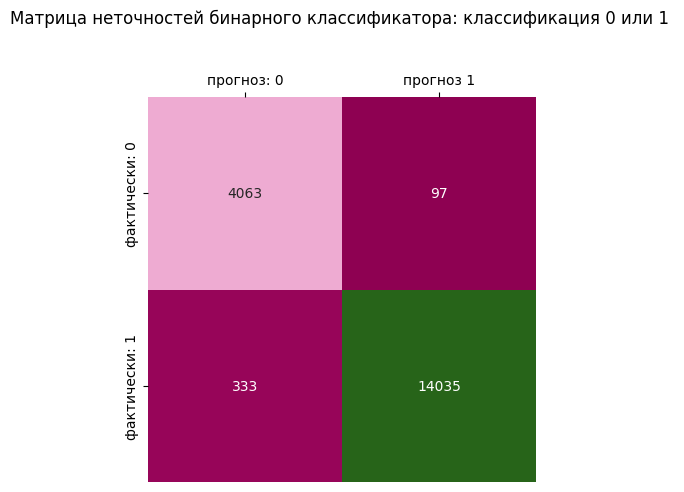

1    14368
0     4160
Name: rating, dtype: int64

In [168]:
confusion_matrix_plot(y_test, y_pred)
y_test.value_counts()

In [169]:
data_result_conf_matrix = (y_pred != y_test).reset_index().rename({'rating': 'bool'}, axis = 1)
indexes_failed = data_result_conf_matrix[data_result_conf_matrix['bool'] == True]['index']

fail = test.loc[indexes_failed]
fail.head()

,body,title,rating,bank_name,date,month,year,weekday,day
38949,в общем мне надо изменить тариф нестандартный ...,нестандартная претензия,1,Тинькофф Банк,2022-11-17 20:21:16,11,2022,3,17
90896,политика банка направлена обмануть клиента в м...,он один такой плохой,0,Тинькофф Банк,2022-09-08 12:37:02,9,2022,3,8
42105,решил открыть дебетовый счет в банке для поезд...,дебетовая карта и неожиданное решение,0,Тинькофф Банк,2022-11-13 14:39:36,11,2022,6,13
59438,25102022 в банкомат находящийся по адресу ст ц...,обслуживание ужасное,1,РНКБ,2022-10-30 13:16:11,10,2022,6,30
91856,в тинькофф у меня есть несколько продуктов а и...,тинькофф удерживает детское пособие и социальн...,0,Тинькофф Банк,2022-09-05 20:16:41,9,2022,0,5


In [170]:
fail.describe().round(2)

,rating,month,year,weekday,day
count,430.00,430.00,430.00,430.00,430.00
mean,0.77,10.79,2022.01,2.88,15.83
std,0.42,1.51,0.11,1.83,8.54
min,0.00,1.00,2022.00,0.00,1.00
25%,1.00,10.00,2022.00,1.00,9.00
50%,1.00,11.00,2022.00,3.00,16.00
75%,1.00,12.00,2022.00,4.00,23.00
max,1.00,12.00,2023.00,6.00,31.00


какие банки представлены в ошибочных предсказаниях ?

In [171]:
fail_bank_name_count = fail['bank_name'].value_counts()\
                                        .sort_values()\
                                        .reset_index()\
                                        .rename({'index': 'bank',
                                                 'bank_name': 'count_fail'}, axis = 1)
fail_bank_name_count.head()

,bank,count_fail
0,Владбизнесбанк,1
1,ОТП Банк,1
2,Банк Зенит,1
3,Азиатско-Тихоокеанский Банк,1
4,Точка,1


In [172]:
train_bank_name_count = train['bank_name'].value_counts()\
                                          .sort_values()\
                                          .reset_index()\
                                          .rename({'index': 'bank', 'bank_name': 'count_train'}, axis = 1)
train_bank_name_count.head()

,bank,count_train
0,МТИ Банк,1
1,Калуга,1
2,TalkBank,1
3,СДМ-Банк,1
4,Гарант-Инвест,1


In [173]:
fail_bank =\
train_bank_name_count.merge(fail_bank_name_count,
                            on = 'bank')

fail_bank['percent'] =(fail_bank['count_fail'] / fail_bank['count_train']) * 100
fail_bank.sort_values(by = 'percent',
                      ascending = False).head()

,bank,count_train,count_fail,percent
0,Владбизнесбанк,1,1,100.000000
1,Москва-Сити,4,1,25.000000
2,Всероссийский Банк Развития Регионов,23,1,4.347826
3,Солидарность,33,1,3.030303
11,Драйв Клик Банк,267,7,2.621723


Ошибки возникают в мало представленных образцах тренировочного набора (это одна из возможных причин)

Text(0.5, 1.0, 'ROC кривая')

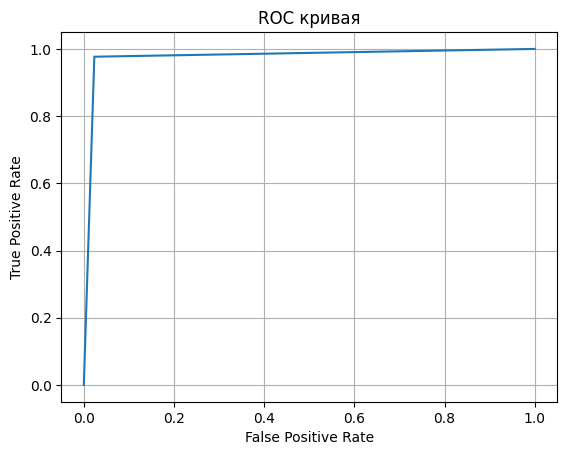

In [174]:
roc_data =\
roc_curve(y_true = y_test,
          y_score = y_pred)

display = RocCurveDisplay(fpr = roc_data[0],
                          tpr = roc_data[1])
display.plot() 
plt.grid()
plt.title('ROC кривая')

In [175]:
fail['len_body'] = fail['body'].map(lambda x: len(x))
fail.sort_values(by = 'len_body').head()

,body,title,rating,bank_name,date,month,year,weekday,day,len_body
73422,перевела деньги на озон карту с помощью сбп сб...,деньги переведённые через сбп не вижу на озон ...,1,Озон Банк,2022-10-27 00:00:17,10,2022,3,27,214
3118,12319 191082 7 22 2 22 3 22 22 2 22 2 22 3 ...,уааааааа,1,Авангард,2022-12-27 17:21:32,12,2022,1,27,223
11574,отправил деньги свой маме на лечение ей отказ...,отправленные деньги украл банк отправил маме н...,1,Юнистрим,2022-12-14 22:25:06,12,2022,2,14,231
86943,мошенники сняли деньги обратился оператору пер...,злоумышленники сняли деньги,1,Тинькофф Банк,2022-09-21 15:04:26,9,2022,2,21,260
26801,нужно было удалить историю покупок на озон это...,озон карта не открывается,1,Озон Банк,2022-12-05 00:32:27,12,2022,0,5,263


<a id = 'model_13'></a>

### Смотрим на конкретные ошибки в предсказании

[к оглавлению](#title)

In [176]:
problem_analyst(
    data = data,
    X_test_in_sparse_type = X_test,
    y_pred = y_pred,
    y_test = y_test,
    TEST_FRAME_INDEX = INDEX_TEST,
    index_you_want = 0,
    real_class = 0,
    transformer = transformer_reviews)

СЛОВА В ОТЗЫВЕ, У КОТОРЫХ ЧАСТОТА TF-IDF НЕ 0
_____________________________________________
Реальный рейтинг выбранного отзыва:  0
_____________________________________________
Текст отзыва: 
пользуемся картой халва уже больше года, очень радует отношения к клиентам , при возникновении непонятных ситуаций всегда оперативно подключаются менеджеры и помогают решить проблему. за время сотрудничества с совкомбанком остаются только приятные впечатления от сервиса взаимодействия с клиентами.
_____________________________________________


,частота,слово,векторное представление
16078,0.113729,больше,16078
18796,0.206796,взаимодействия,18796
21121,0.247911,возникновении,21121
22231,0.210102,впечатления,22231
22473,0.096319,время,22473
22587,0.10251,всегда,22587
27063,0.105356,года,27063
35441,0.061359,за,35441
45977,0.111165,картой,45977
47281,0.137677,клиентам,47281


В представленном отзыве есть слово 'нраится' / 'отлично' / 'супер'. Этим словам придается повышенная частота (реже встречается в отзывах. Принцип работы TF-IDF). И модель справедливо оценивает этот образец положительно , но почему-то изначальный рейтинг у него был:
    - 0 в бинарной классификации
    - 1 (из 5) в изначальной классификации

Т.е. рейтинг этого отзыва изначально был странным

---

Посмотрим еще отзыв:

In [177]:
proba_2 =\
problem_analyst(
    data = data,
    X_test_in_sparse_type = X_test,
    y_pred = y_pred,
    y_test = y_test,
    TEST_FRAME_INDEX = INDEX_TEST,
    index_you_want = 1, # Беру первый индекс
    real_class = 1, # Класс положительный (изначально положительный)
    transformer = transformer_reviews)

proba_2.sort_values(by = 'частота',
                    ascending = False).head(15) # 15 самых не частых слов

СЛОВА В ОТЗЫВЕ, У КОТОРЫХ ЧАСТОТА TF-IDF НЕ 0
_____________________________________________
Реальный рейтинг выбранного отзыва:  1
_____________________________________________
Текст отзыва: 
. . ? 12319 191082 7 22 2 22 3 22 22 2 22 2 22 3 221672058048166 4121574 7 0 7 227620630410297896 7 0 22 2 22 22 3 222 22 2 22 22 3 22 22 2 22 3 22 3 22 22 2 22 5 22 3 220 7 43 3588 1 22 429 75 53536843954 22 2 22 22 3 22 22 7
_____________________________________________


,частота,слово,векторное представление
3328,0.975524,22,3328
4994,0.110189,3588,4994
5665,0.101173,429,5665
3574,0.09539,222,3574
3329,0.084764,220,3329
5673,0.070364,43,5673
7866,0.068854,75,7866


В данном отзыве - рейтинг 1 (положительный). 

Опять же, по тексту понятно - рейтинг отрицательный, но почему-то авторами отзыва отмечен как положительный (1)

---

Посмотрим еще отзыв:

In [178]:
proba_3 =\
problem_analyst(
    data = data,
    X_test_in_sparse_type = X_test,
    y_pred = y_pred,
    y_test = y_test,
    TEST_FRAME_INDEX = INDEX_TEST,
    index_you_want = 7, 
    real_class = 1,
    transformer = transformer_reviews)

proba_3.sort_values(by = 'частота',
                    ascending = False).head(15) # 15 самых не частых слов

СЛОВА В ОТЗЫВЕ, У КОТОРЫХ ЧАСТОТА TF-IDF НЕ 0
_____________________________________________
Реальный рейтинг выбранного отзыва:  1
_____________________________________________
Текст отзыва: 
подключил премиальное обслуживание и далее в службе поддержки сообщили, что банк работает только с сервисом . этот сервис за границей включает только несколько городов. как сообщили в поддержке чеки за проходы в бизнес залы с других стран не компенсируют. разочарован . буду расторгать договор.
_____________________________________________


,частота,слово,векторное представление
114626,0.288356,сообщили,114626
27381,0.273445,городов,27381
48620,0.26262,компенсируют,48620
100188,0.257761,проходы,100188
104695,0.253591,расторгать,104695
118100,0.240744,стран,118100
19718,0.236723,включает,19718
37922,0.233747,залы,37922
93601,0.230787,премиальное,93601
102940,0.201313,разочарован,102940


Опять по тексту понятно, что отзыв отрицательный, но в фрейме помечен, как положительный

In [179]:
proba_4 =\
problem_analyst(
    data = data,
    X_test_in_sparse_type = X_test,
    y_pred = y_pred,
    y_test = y_test,
    TEST_FRAME_INDEX = INDEX_TEST,
    index_you_want = 11, 
    real_class = 0,
    transformer = transformer_reviews)

proba_4.sort_values(by = 'частота',
                    ascending = False).head(20) # 20 самых не частых слов

СЛОВА В ОТЗЫВЕ, У КОТОРЫХ ЧАСТОТА TF-IDF НЕ 0
_____________________________________________
Реальный рейтинг выбранного отзыва:  0
_____________________________________________
Текст отзыва: 
к сожалению банк не доставляет карты по выходным дням по крайней мере в моем городе ,а я работаю с 8 до 17,а доставка до 18 на работе нет возможности выйти за территорию ,так вот представитель компании созванивались несколько раз,и привезла карту в 17.40 домой как я и просил в комментариях к доставке так что я очень рад!
_____________________________________________


,частота,слово,векторное представление
120801,0.294492,территорию,120801
114160,0.270244,созванивались,114160
2457,0.2605,17,2457
25734,0.236642,выходным,25734
30953,0.232512,дням,30953
94202,0.224834,привезла,94202
48403,0.222861,комментариях,48403
33017,0.215486,доставляет,33017
50626,0.192155,крайней,50626
24237,0.191974,выйти,24237


Отзыв скорее нейтральный, модель возможно ошибается опять же из-за больших весов позитивных слов

<a id = 'model_14'></a>

## Вывод

[к оглавлению](#title)

- Точность хорошая по нескольким причинам:
    - много обучающих образцов
    - при upsampling образцы фактически копируются, а значит модель будет пытаться запоминать образцы и когда встречает такой же проблем у нее не возникает
    - при downsampling модель чуть хуже, т.к. все образцы уникальные


- Ошибок на классе 1 больше, т.к. до upsampling класс 1 - был превалирующий, а 0 класс мы клонировали --> модель замечает повторы образцов 0 класса и подстраивается, а все образцы класса 1 - уникальные, поэтому она их предсказывает хуже
- Ошибки также возникают на банках, у которых мало отзывов (у них доля неправильно предсказанных больше) + наложение клонирования при upsampling
- Ошибки возникают в мало представленных образцах тренировочного набора
- Также при просмотре конкретных ошибочно предсказанных образцов - выяснилось, что есть отрицательные отзывы, но по какой-то причине они отмечены, как положительные и наоборот
- Есть образцы, в которых масштабирование TF-IDF дает большие веса позитивным словам, а рейтинг отзыва - нейтральный по тексту



Модель:

- LogisticRegression()
- Балансировка классов методом Upsampling
- Accuracy_test =  0.98254

In [180]:
result.T.sort_values(by = 'test_acc',
                     ascending = False)

,name,balance_mode,solver,iteration,penalty,test_acc,train_acc,train_loss,lr,test_loss
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN
0,log_reg,upsampling,lbfgs,100,l2,0.976792,NaN,NaN,NaN,NaN


In [181]:
joblib.dump(model, 'log_reg_itog.pkl')

['log_reg_itog.pkl']